In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import MissingIndicator, SimpleImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.inspection import permutation_importance


In [4]:
#train.Gender.isna().sum()

13

In [3]:
train = pd.read_csv("data/train.csv", index_col=0)
test = pd.read_csv("data/test.csv", index_col=0)  # does not contain targets

#Gender
##train_no_gender = train.copy().drop(columns="Gender")
##test_no_gedner = test.copy().drop(columns="Gender")

train_no_gender = train.copy().dropna(subset=["Gender"])
test_no_gender = test.copy().dropna(subset=["Gender"])

le = LabelEncoder()
train_no_gender.Gender = le.fit_transform(train_no_gender.Gender)
test_no_gender.Gender = le.transform(test_no_gender.Gender)

# Married
train_no_nan_married = train_no_gender.copy().dropna(axis=0, subset=["Married"])
train_no_nan_married = pd.get_dummies(train_no_nan_married, columns=["Married"], drop_first=True)

# Dependents
train_dependent_only_int = train_no_nan_married.copy().replace("3+", 3)
for number in range(0, 3):
    train_dependent_only_int = train_dependent_only_int.replace(f"{number}", number)

train_dependents_no_nan = train_dependent_only_int.copy()


# Education
train_education_dummies = pd.get_dummies(train_dependents_no_nan.copy(), columns=["Education"], drop_first=True)

train_self_employed_encoded = train_education_dummies.copy()

# Self_Employed

train_self_employed_encoded.Self_Employed = train_self_employed_encoded.Self_Employed.replace(["No", "Yes"], [0, 1]) 

# Loan_Amount_Term
si = SimpleImputer(strategy="median")

train_imputed_loan_amount_term = train_self_employed_encoded.copy()
train_imputed_loan_amount_term.Loan_Amount_Term = si.fit_transform(train_imputed_loan_amount_term.Loan_Amount_Term.values.reshape(-1, 1))

# Credit_History



# Property_Area and Loan_Status
train_property_area_n_target = pd.get_dummies(train_imputed_loan_amount_term.copy(), columns=["Property_Area", "Loan_Status"], drop_first=True)

# Loan amount
train_LoanAmount_itterative_imputer = train_property_area_n_target.copy()

X = train_LoanAmount_itterative_imputer.iloc[:, :-1]
y = train_LoanAmount_itterative_imputer.iloc[:, -1]

imp_mean = IterativeImputer(random_state=0)
X = imp_mean.fit_transform(X)

X = pd.DataFrame(X, columns=train_LoanAmount_itterative_imputer.iloc[:, :-1].columns)

## Transform continous data to be more normal

In [5]:
X.ApplicantIncome = np.sqrt(X.ApplicantIncome.values)
X.CoapplicantIncome = np.sqrt(X.CoapplicantIncome)

## Split and train

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=123)

In [12]:
pipe = make_pipeline(StandardScaler(),
                     #PCA(),
                     LogisticRegression())

pipe.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

In [13]:
params = [{
    #'pca__n_components': [6,7,8,9,10,11],
    'logisticregression__penalty': ['l2', 'l1'],
    'logisticregression__C': [x for x in np.arange(0.01, 1.5, 0.01)],
    'logisticregression__solver': ['lbfgs', 'liblinear']
}#, {
 #   'logisticregression__penalty': ['elasticnet'],
 #   'logisticregression__C': [x for x in np.arange(0.1, 1.5, 0.1)],
 #   'logisticregression__l1_ratio': [x for x in np.arange(0, 1, 0.01)],
 #   'logisticregression__solver': ['saga']
#}
]

gs = GridSearchCV(estimator=pipe,
                 param_grid=params,
                 scoring="accuracy",
                 n_jobs=-1,
                 cv=5)

In [14]:
%%time
gs = gs.fit(X_train, y_train)

Wall time: 7.49 s


In [15]:
print(f"Best score: {gs.best_score_}")
print(f"Best params:\n{gs.best_params_}")

Best score: 0.8101330203442879
Best params:
{'logisticregression__C': 0.02, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}


In [16]:
for r, _ in enumerate(gs.cv_results_['mean_test_score']):
    print("%0.4f +/- %0.4f %r"
          % (gs.cv_results_['mean_test_score'][r],
             gs.cv_results_['std_test_score'][r],
             gs.cv_results_['params'][r]))

0.7933 +/- 0.0179 {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
0.8074 +/- 0.0329 {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
nan +/- nan {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'lbfgs'}
0.3128 +/- 0.0056 {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.8101 +/- 0.0282 {'logisticregression__C': 0.02, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
0.8074 +/- 0.0329 {'logisticregression__C': 0.02, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
nan +/- nan {'logisticregression__C': 0.02, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'lbfgs'}
0.8101 +/- 0.0282 {'logisticregression__C': 0.02, 'logisticregression__penalty': 'l1', 'logisticregression__solver': '

In [17]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f"Test accuracy: {clf.score(X_test, y_test):.5f}")  # Looking at how the model preformed against the test set

Test accuracy: 0.80417


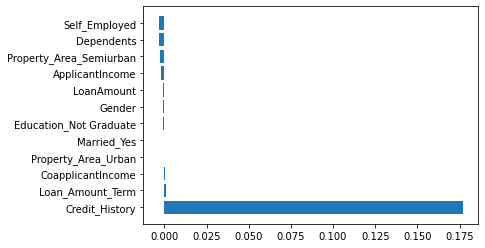

In [119]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=11111)

clf = gs.best_estimator_
clf.fit(X_train, y_train)

# Permute
result = permutation_importance(clf, X_test, y_test, n_repeats=100, random_state=0)

# Plot importances
ind = indices = np.argsort(result.importances_mean)[::-1]
plt.barh(X.columns[ind], result.importances_mean[ind])
plt.show()

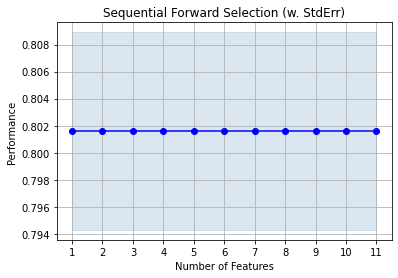

In [120]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Prepare SFS
sfs = SFS(gs.best_estimator_, 
          k_features=(2, 11), 
          forward=True,   # Change to False to get backwards selection
          floating=False, 
          scoring='accuracy',
          cv=5)

# Fit'n plot
sfs = sfs.fit(X_train, y_train)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

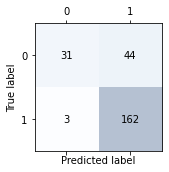

In [18]:
from sklearn.metrics import confusion_matrix
predictions = clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=predictions)   # Creating a confusion matrix by compairing true target against predicted target

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig("confusion_matrix_LR")
plt.show()